In [52]:
from google.colab import drive
import pandas as pd
!python -m spacy download ru_core_news_sm
!gdown 1i36nMhDv2kJbF2CiW493dXtWTzGG1RGd

df=pd.read_csv('/content/messages.csv') # Лишние столбцы channel, mentions, pinned, author_id, attachements(?),

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 31.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Downloading...
From: https://drive.google.com/uc?id=1i36nMhDv2kJbF2CiW493dXtWTzGG1RGd
To: /content/messages.csv
100% 65.0M/65.0M [00:00<00:00, 259MB/s]


In [19]:
df

,attachments,author,author_id,channel,content,created_at,id,mentions,pinned
0,[],user1,318342675692519424,✨glavnij-малочисленные-народы-южного-красноярска,идем в роблокс серф,2024-11-16T10:37:22.314000+00:00,1307293431109914644,[],False
1,[],user1,318342675692519424,✨glavnij-малочисленные-народы-южного-красноярска,https://www.youtube.com/watch?v=okmpec8dJNU,2024-11-16T10:37:19.062000+00:00,1307293417469902868,[],False
2,[],user1,318342675692519424,✨glavnij-малочисленные-народы-южного-красноярска,<@338164090818134036>,2024-11-15T14:46:31.937000+00:00,1306993746507858053,['n0isy1'],False
3,[],user6,1121052674188640266,✨glavnij-малочисленные-народы-южного-красноярска,на мобилке?,2024-11-14T14:29:09.325000+00:00,1306626985610575913,['mow2zxc'],False
4,[],user9,434317967182921729,✨glavnij-малочисленные-народы-южного-красноярска,Какое VPN расширение или приложение можно скач...,2024-11-14T10:56:43.474000+00:00,1306573525636616212,[],False
...,...,...,...,...,...,...,...,...,...
295028,[],user1,318342675692519424,✨glavnij-малочисленные-народы-южного-красноярска,Он удобнее,2018-01-09T05:38:36.614000+00:00,400161417678028800,[],False
295029,[],user1,318342675692519424,✨glavnij-малочисленные-народы-южного-красноярска,Эволюционируют в дискорд,2018-01-09T05:38:34.117000+00:00,400161407204589570,[],False
295030,[],user1,318342675692519424,✨glavnij-малочисленные-народы-южного-красноярска,"Все, кого приглашаю сюда",2018-01-09T05:38:27.171000+00:00,400161378071085067,[],False
295031,[],user1,318342675692519424,✨glavnij-малочисленные-народы-южного-красноярска,Кароче тема такая,2018-01-09T05:38:18.853000+00:00,400161343182864384,[],False


In [20]:
!pip install aiohttp

## Топ гифок по юзерам

In [64]:
import requests, aiohttp, asyncio, nest_asyncio
from bs4 import BeautifulSoup
import requests

def filter_gifs_by_user(dataframe, username):
    gifs_df = dataframe[dataframe['content'].str.contains('tenor.com', na=False)]
    return gifs_df[gifs_df['author'] == username]

async def get_gif_url(session, tenor_url):
    try:
        async with session.get(tenor_url) as response:
            if response.status == 200:
                html = await response.text()
                soup = BeautifulSoup(html, 'html.parser')
                meta_tag = soup.find('meta', property='og:image')
                if meta_tag and 'content' in meta_tag.attrs:
                    return meta_tag['content']
    except Exception as e:
        print(f"Error fetching GIF URL for {tenor_url}: {e}")
    return None

async def process_user_gifs(username, dataframe):
    gifs_df = filter_gifs_by_user(dataframe, username)
    gifs_df['link'] = gifs_df['content'].str.extract(r'(https?://tenor\.com/\S+)', expand=False)

    print(f"Processing GIFs for user {username}...")

    async with aiohttp.ClientSession() as session:
        tasks = [get_gif_url(session, url) for url in gifs_df['link'].dropna()]
        results = await asyncio.gather(*tasks)

    gifs_df = gifs_df[gifs_df['link'].notna()].copy()
    gifs_df['direct_gif_url'] = results

    gifs_grouped_df = gifs_df.groupby('direct_gif_url').size().reset_index(name='count')
    gifs_grouped_df = gifs_grouped_df[gifs_grouped_df['direct_gif_url'].notna()]

    print(f"Unique GIFs for {username}: {len(gifs_grouped_df)}")

    gifs_grouped_df = gifs_grouped_df.sort_values(by='count', ascending=False).head(150)
    gifs_grouped_df['GIF'] = gifs_grouped_df['direct_gif_url'].apply(lambda x: f'<img src="{x}" width="700">')

    top_20_gifs = gifs_grouped_df.head(20)
    filename = f'top_gifs_{username}.html'
    html = top_20_gifs[['count', 'GIF']].to_html(escape=False, index=False)
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(html)

    print(f"HTML file with top 20 GIFs saved as '{filename}'.")

users = ['user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8', 'user9']

try:
    loop = asyncio.get_running_loop()
except RuntimeError:
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

tasks = [process_user_gifs(user, df) for user in users]

if loop.is_running():
    nest_asyncio.apply()
    asyncio.run(asyncio.gather(*tasks))
else:
    loop.run_until_complete(asyncio.gather(*tasks))


Processing GIFs for user user1...
Processing GIFs for user user2...
Processing GIFs for user user3...
Processing GIFs for user user4...
Processing GIFs for user user5...
Processing GIFs for user user6...
Processing GIFs for user user7...
Processing GIFs for user user8...
Processing GIFs for user user9...
Unique GIFs for user9: 59
HTML file with top 20 GIFs saved as 'top_gifs_user9.html'.
Unique GIFs for user6: 24
HTML file with top 20 GIFs saved as 'top_gifs_user6.html'.
Unique GIFs for user8: 31
HTML file with top 20 GIFs saved as 'top_gifs_user8.html'.
Unique GIFs for user4: 141
HTML file with top 20 GIFs saved as 'top_gifs_user4.html'.
Unique GIFs for user7: 162
HTML file with top 20 GIFs saved as 'top_gifs_user7.html'.
Unique GIFs for user3: 303
HTML file with top 20 GIFs saved as 'top_gifs_user3.html'.
Unique GIFs for user1: 1481
HTML file with top 20 GIFs saved as 'top_gifs_user1.html'.
Unique GIFs for user5: 785
HTML file with top 20 GIFs saved as 'top_gifs_user5.html'.
Unique G

# Подготовка данных

## Очистка данных

In [23]:
# Удалим лишние столбцы
df.info
df = df.drop(columns=['channel', 'pinned', 'mentions', 'author_id', 'id', 'attachments'])

In [ ]:
import re
# Удалить слова в скобках <>
df['content'] = df['content'].str.replace(r'<.*?>', '', regex=True)

# Удалить ссылки
df['content'] = df['content'].str.replace(r'https?://\S+', '', regex=True)


df = df[df['content'].notna()]
df = df[df['content'] != '']

# Преобразование столбца created_at в datetime
df['created_at'] = pd.to_datetime(df['created_at'], format='mixed', errors='coerce')


# Очистка текста от лишних символов
df['content'] = df['content'].apply(lambda text: re.sub(r"[^а-яА-ЯёЁa-zA-Z0-9\s]", "", text))


#Перевод времени в московское
df['created_at'] = df['created_at'] + pd.Timedelta(hours=3)
# Результат
df.head(100)

## Группировка сообщений

In [ ]:
print("Изначальная длина датафрейма:", len(df))

# Сортируем по автору и времени
df = df.sort_values(by=['author', 'created_at'])

# Создаем пустой список для объединенных записей
grouped_content = []
grouped_authors = []
grouped_times = []

# Итерация по строкам
current_group = []  # Для хранения групп сообщений
prev_time = None
prev_author = None

for _, row in df.iterrows():
    # Приводим content к строке, если это не строка
    content = str(row['content']) if not isinstance(row['content'], str) else row['content']

    # Если автор тот же и разница во времени менее 20 минут
    if prev_author == row['author'] and (row['created_at'] - prev_time).seconds <= 1200:
        current_group.append(content)  # Добавляем контент к текущей группе
    else:
        # Если группа не пустая, добавляем предыдущую группу в итог
        if current_group:
            grouped_content.append(' '.join(current_group))
            grouped_authors.append(prev_author)
            grouped_times.append(prev_time)

        # Начинаем новую группу
        current_group = [content]

    prev_time = row['created_at']
    prev_author = row['author']

# Добавляем последнюю группу
if current_group:
    grouped_content.append(' '.join(current_group))
    grouped_authors.append(prev_author)
    grouped_times.append(prev_time)

# Новый DataFrame с объединенными сообщениями
df_grouped = pd.DataFrame({
    'content': grouped_content,
    'author': grouped_authors,
    'created_at': grouped_times
})

# Выводим результат
df = df_grouped.sort_values(by='created_at', ascending=False).reset_index(drop=True)
print("Длина датафрейма после группировки сообщений:", len(df))
df.head(100)

In [ ]:
# Удалить строки с менее чем 4 словом
df = df[df['content'].str.split().str.len() >= 4].reset_index(drop=True)
print(len(df))
df.head(100)

In [27]:
!pip install pymorphy3 nltk

## Лемматизация, удаление стоп-слов

In [28]:
import pandas as pd
import re
import pymorphy3
from nltk.corpus import stopwords
import nltk

# Инициализация инструментов
morph = pymorphy3.MorphAnalyzer()

# # Функция для коррекции орфографии
# def correct_spelling(text):
#     words = text.split()
#     corrected_words = [spell.correction(word) if spell.correction(word) is not None else word for word in words]
#     return ' '.join(corrected_words)

# Функция для лематизации
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmatized_words)

def remove_stopwords(text, stopwords):
    # Удаление знаков препинания и приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text).lower()
    # Удаление стоп-слов
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

# Очистка текста от лишних символов
df['content'] = df['content'].apply(lambda text: re.sub(r"[^а-яА-ЯёЁa-zA-Z0-9\s]", "", text).lower())

# Лематизация текста
df['content'] = df['content'].apply(lemmatize_text)

# Удаление стоп слов
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))
custom_stopwords = {"чё", "че"}
russian_stopwords.update(custom_stopwords)
df['content'] = df['content'].apply(lambda text: remove_stopwords(text, russian_stopwords))

df.to_csv('processed_data.csv', index=False, encoding='utf-8')

# Результат
df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,content,author,created_at
0,идти роблокс серф,user1,2024-11-16 13:37:22.314000+00:00
1,vpn расширение приложение скачать сидеть дс,user9,2024-11-14 13:56:43.474000+00:00
2,thats why they call me,user1,2024-11-10 16:05:55.914000+00:00
3,всё снова слить шейти,user2,2024-11-10 16:05:47.296000+00:00
4,ое около нефора панк,user1,2024-11-10 15:23:12.992000+00:00
...,...,...,...
21376,добавить смайл рядовой юзер детишки сэмпл мочь...,user1,2018-01-09 13:03:11.245000+00:00
21377,сёма пидераст комната свой вернуться,user1,2018-01-09 09:30:31.983000+00:00
21378,почему го майн илмить,user4,2018-01-09 09:03:28.136000+00:00
21379,пойти гмода хотеть,user1,2018-01-09 09:03:24.787000+00:00


# Анализ

## Определение периода активности для пользователя

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def show_activity_user(user):
  user_name = user

  user_data = df[df['author'] == user_name]

  user_data['hour'] = user_data['created_at'].dt.hour

  hourly_activity = user_data['hour'].value_counts().sort_index()

  plt.figure(figsize=(10, 6))
  hourly_activity.plot(kind='bar', color='skyblue', edgecolor='black')
  plt.title(f"Активность пользователя {user_name} по часам суток", fontsize=14)
  plt.xlabel("Час суток", fontsize=12)
  plt.ylabel("Количество сообщений", fontsize=12)
  plt.xticks(rotation=0)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()


<ipython-input-29-41b616746496>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['hour'] = user_data['created_at'].dt.hour


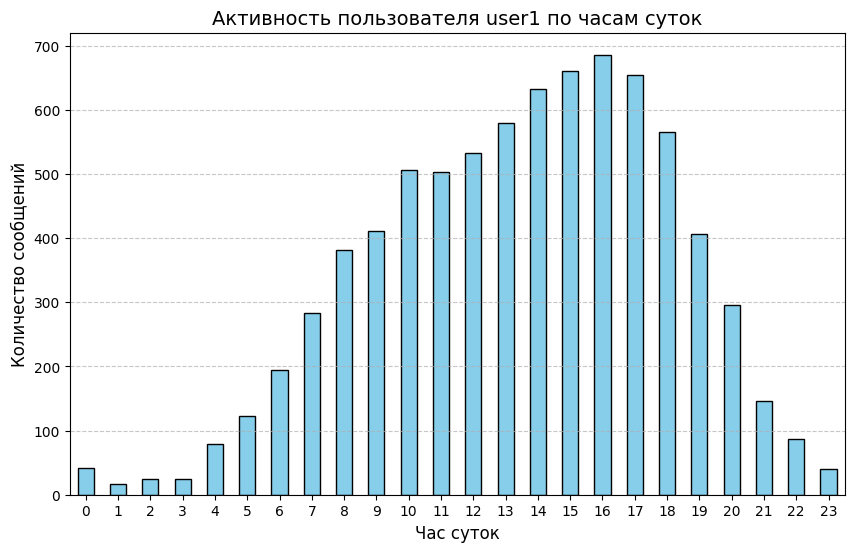

In [30]:
show_activity_user("user1")

<ipython-input-29-41b616746496>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['hour'] = user_data['created_at'].dt.hour


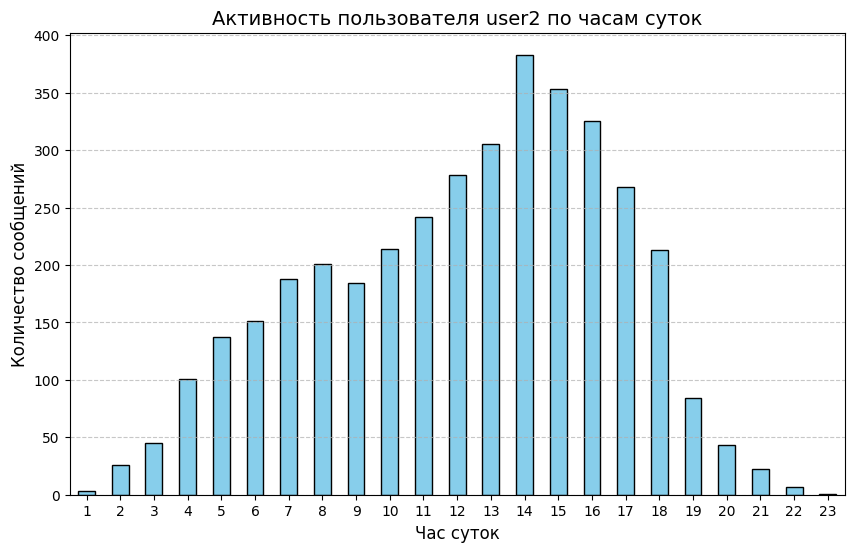

In [31]:
show_activity_user("user2")

<ipython-input-29-41b616746496>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['hour'] = user_data['created_at'].dt.hour


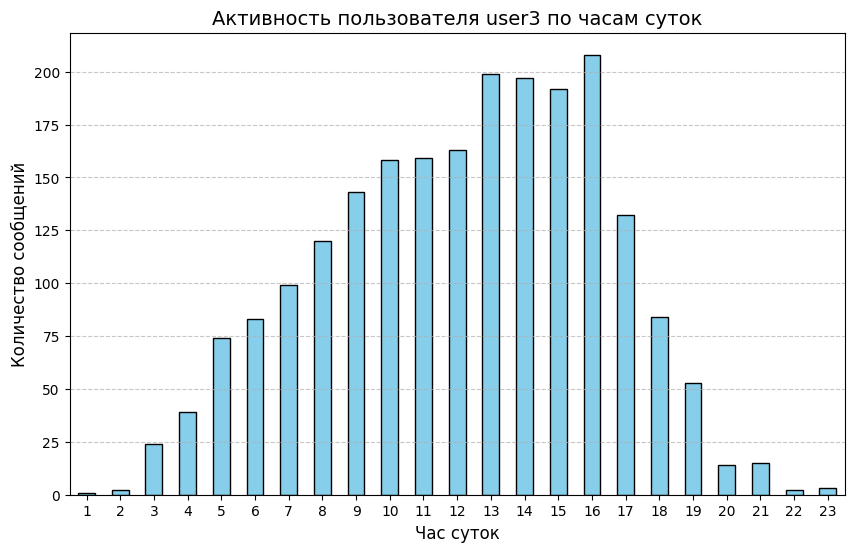

In [32]:
show_activity_user("user3")

<ipython-input-29-41b616746496>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['hour'] = user_data['created_at'].dt.hour


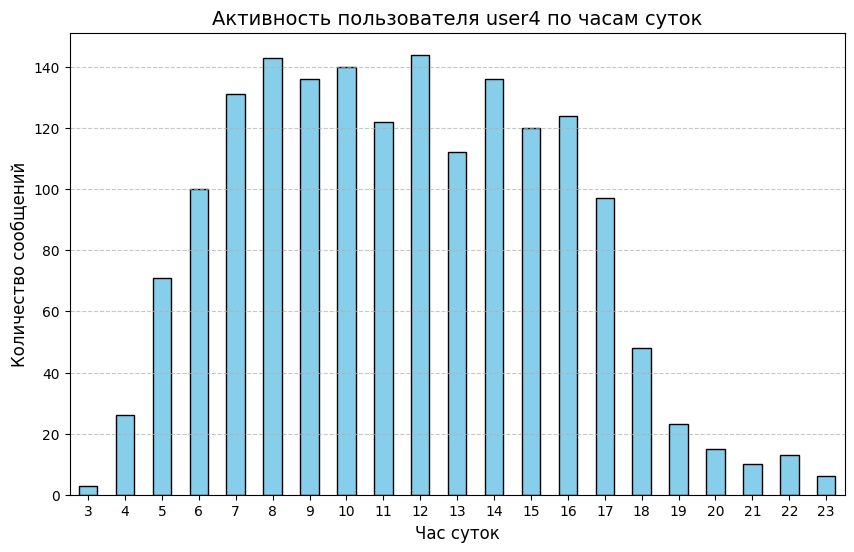

In [33]:
show_activity_user("user4")

## Анализ частоты использования ненормативной лексики для пользователя

In [35]:
!gdown 1EAQFXPSdDTCrnGQA1J0H4_48EYish9G0

Downloading...
From: https://drive.google.com/uc?id=1EAQFXPSdDTCrnGQA1J0H4_48EYish9G0
To: /content/obscene_corpus.txt
100% 152k/152k [00:00<00:00, 111MB/s]


In [36]:
with open("/content/obscene_corpus.txt", "r", encoding="utf-8") as f:
    obscene_words = set([line.strip().lower() for line in f if line.strip()])

def count_obscene_words(message, obscene_words):
    words = message.lower().split()
    return sum(word in obscene_words for word in words)
# Применение функции к каждому сообщению
df['obscene_word_count'] = df['content'].apply(lambda x: count_obscene_words(x, obscene_words))

# Общее количество нецензурных слов по автору
obscene_counts_by_author = df.groupby('author')['obscene_word_count'].sum()
obscene_counts_by_author = obscene_counts_by_author.sort_values(ascending=False)

# Вывод результатов
print("\nКоличество нецензурных слов по авторам (отсортированное):")
print(obscene_counts_by_author)

# Частота использования нецензурных слов по автору
df['word_count'] = df['content'].apply(lambda x: len(x.split()))
total_words_by_author = df.groupby('author')['word_count'].sum()
obscene_frequency = obscene_counts_by_author / total_words_by_author

obscene_frequency = obscene_frequency.sort_values(ascending=False)

# Вывод результатов
print("\nЧастота использования нецензурных слов по авторам (отсортированная):")
print(obscene_frequency)


Количество нецензурных слов по авторам (отсортированное):
author
user1    8708
user2    2857
user3    2281
user7    1416
user5     618
user9     565
user6     392
user8     371
user4     283
Name: obscene_word_count, dtype: int64

Частота использования нецензурных слов по авторам (отсортированная):
author
user7    0.079671
user3    0.058931
user5    0.047974
user6    0.044535
user1    0.039642
user9    0.039387
user2    0.037758
user8    0.017763
user4    0.009348
dtype: float64


## Определение эмоционального состояния (сентимент-анализ)

In [37]:
pip install transformers torch datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [44]:
df_e = df.copy()

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'blanchefort/rubert-base-cased-sentiment-med' # 'blanchefort/rubert-base-cased-sentiment'

tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True)

model.to(device)

@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt').to(device)
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).cpu().numpy()
    return predicted[0]


df_e['sentiment'] = df_e['content'].apply(predict)

sentiment_mapping = {0: "нейтрально", 1: "позитив", 2: "негатив"}
df_e['sentiment_label'] = df_e['sentiment'].map(sentiment_mapping)

# df_e = df_e[df_e['sentiment'] != 0]
# print(len(df_e[df_e['sentiment'] == 1]))


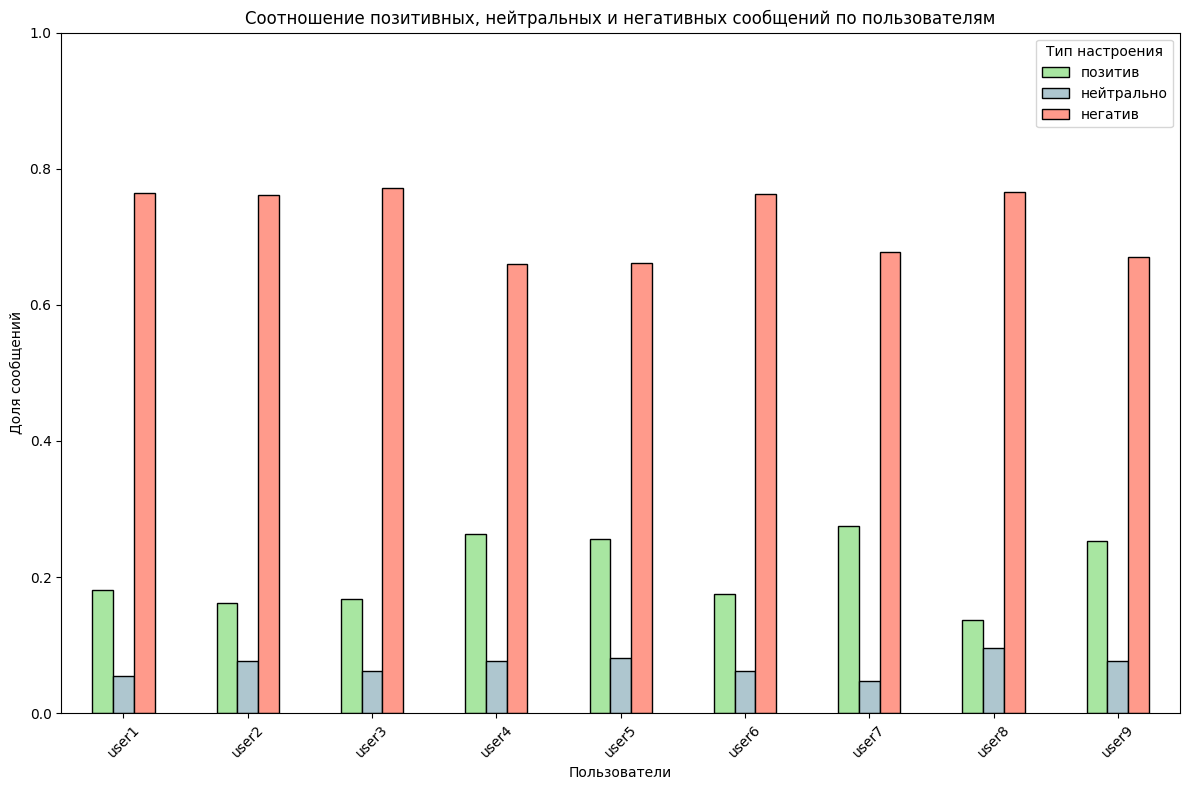

In [47]:
def plot_user_sentiment_ratios(df):
    # Группируем данные по авторам и меткам настроения
    grouped_data = df.groupby(['author', 'sentiment_label']).size().unstack(fill_value=0)

    grouped_data = grouped_data[['позитив', 'нейтрально', 'негатив']]

    ratio_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)

    ax = ratio_data.plot(
        kind='bar',
        figsize=(12, 8),
        color=['#A8E6A1', '#AEC6CF', '#FF9A8B'],
        edgecolor='black'
    )

    ax.set_ylim(0, 1)

    plt.title('Соотношение позитивных, нейтральных и негативных сообщений по пользователям')
    plt.xlabel('Пользователи')
    plt.ylabel('Доля сообщений')
    plt.legend(title='Тип настроения', loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Вызов функции для отображения гистограммы
plot_user_sentiment_ratios(df_e)

## Тематический анализ (ключевые слова)

In [42]:
!pip install keybert
!pip install transformers datasets scikit-learn

In [48]:
import spacy
import pandas as pd
from collections import Counter

nlp = spacy.load('ru_core_news_sm')

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

# Применение к каждому сообщению
df['entities'] = df['content'].apply(extract_entities)

# Подсчет наиболее упоминаемых сущностей
entities_flat = [entity for sublist in df['entities'] for entity in sublist]
entity_counts = Counter(entities_flat)

# Вывод наиболее упоминаемых сущностей
print(entity_counts.most_common())

[('кс', 707), ('юра', 318), ('жек', 294), ('пох', 280), ('изя', 235), ('мб', 167), ('изз', 141), ('цив', 137), ('ес', 128), ('россия', 113), ('афк', 108), ('вк', 86), ('ммм', 84), ('матан', 81), ('ярик пидорас лох гондон', 80), ('обнова', 78), ('дот', 73), ('пк', 72), ('ооо', 68), ('инф', 67), ('го', 66), ('го кс', 61), ('крым', 55), ('украина', 54), ('денис', 53), ('оф', 51), ('скин', 46), ('спс', 45), ('p', 45), ('сг', 44), ('сука', 43), ('ск', 43), ('китай', 42), ('никита', 42), ('комп', 41), ('красноярск', 40), ('москва', 38), ('путин', 34), ('мда', 34), ('нап', 34), ('пнх', 34), ('це', 33), ('геймдева', 32), ('сша', 31), ('кс када', 30), ('огэ', 29), ('макс', 28), ('америка', 28), ('ярик', 27), ('рф', 26), ('ссср', 25), ('экз', 25), ('вс', 25), ('лондон', 24), ('анальчик пальчик', 24), ('гусев', 23), ('инсайд', 22), ('анастасия анатолиевич', 21), ('вск', 21), ('диса', 21), ('хелп', 21), ('хах', 19), ('турция', 19), ('егор', 19), ('орига', 18), ('оо', 18), ('европа', 18), ('дима', 

In [49]:
def get_top_entities_for_author(df, top_n=20):
    top_entities_by_author = {}

    for author, group in df.groupby('author'):
        # Список всех упомянутых сущностей для данного автора
        entities_flat = [entity for sublist in group['entities'] for entity in sublist]
        entity_counts = Counter(entities_flat)

        # Получение топ N наиболее упоминаемых сущностей
        top_entities_by_author[author] = entity_counts.most_common(top_n)

    return top_entities_by_author

# Получение топ 20 наиболее упоминаемых сущностей для каждого автора
top_entities = get_top_entities_for_author(df, top_n=20)

# Вывод результатов
for author, entities in top_entities.items():
    print(f"Автор: {author}")
    for entity, count in entities:
        print(f"  {entity}: {count}")
    print()

Автор: user1
  кс: 220
  юра: 190
  пох: 171
  жек: 171
  изя: 164
  мб: 88
  россия: 68
  изз: 55
  афк: 55
  цив: 48
  обнова: 46
  вк: 44
  инф: 34
  крым: 30
  матан: 30
  украина: 29
  ес: 29
  спс: 29
  денис: 27
  скин: 26

Автор: user2
  кс: 52
  изз: 41
  ооо: 27
  пк: 26
  мб: 26
  ммм: 24
  денис: 23
  изя: 20
  вк: 17
  мда: 15
  красноярск: 15
  сг: 15
  инф: 14
  китай: 14
  сука: 14
  ес: 13
  сша: 13
  украина: 13
  россия: 13
  рф: 12

Автор: user3
  кс: 81
  ес: 48
  пох: 42
  юра: 39
  жек: 34
  афк: 32
  цив: 27
  дот: 26
  изя: 19
  оф: 17
  пнх: 17
  вк: 16
  мб: 11
  изз: 9
  сг: 9
  никита: 8
  го: 7
  го кс: 7
  ва: 7
  огэ: 6

Автор: user4
  жек: 58
  кс: 54
  юра: 35
  го: 30
  цив: 30
  кс када: 30
  ммм: 26
  ес: 16
  фег: 13
  ск: 10
  го кс: 10
  дип: 9
  зач: 9
  изя: 9
  мб: 9
  комп: 8
  це: 8
  го дип: 7
  никита: 7
  москва: 6

Автор: user5
  кс: 22
  юра: 15
  пк: 13
  мб: 12
  изя: 11
  россия: 9
  дот: 8
  хах: 8
  ооо: 7
  сука: 7
  мда: 7
  изз:

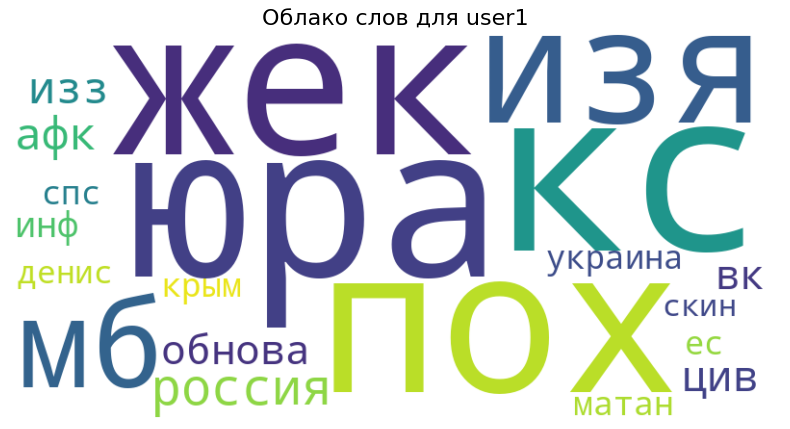

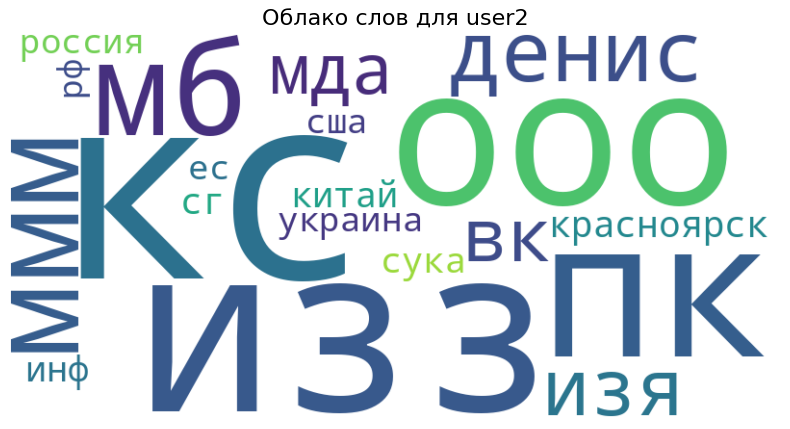

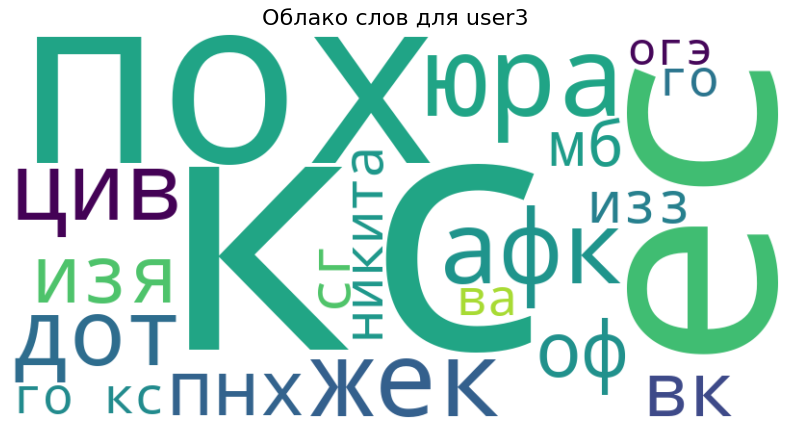

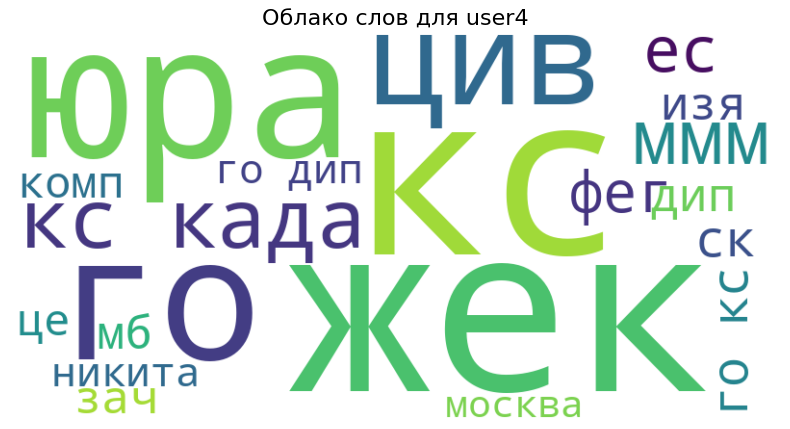

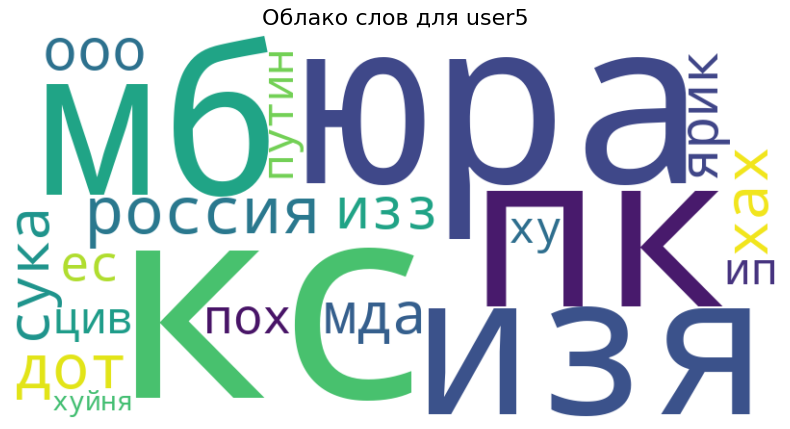

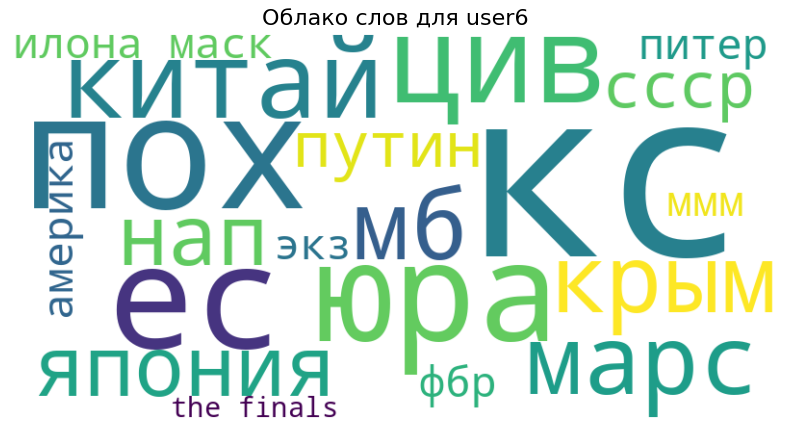

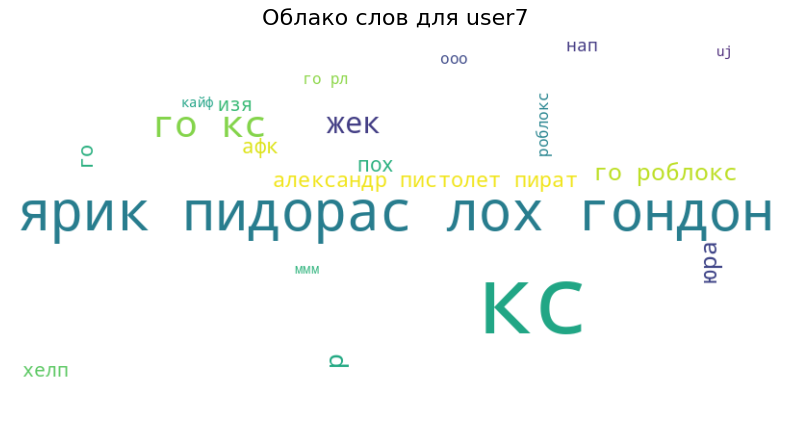

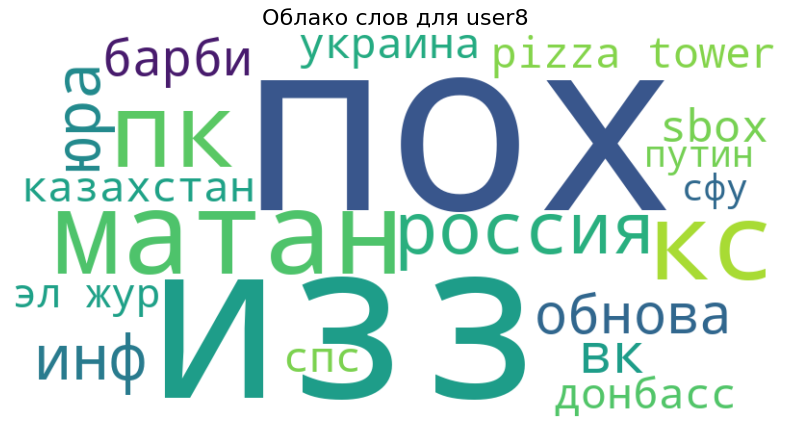

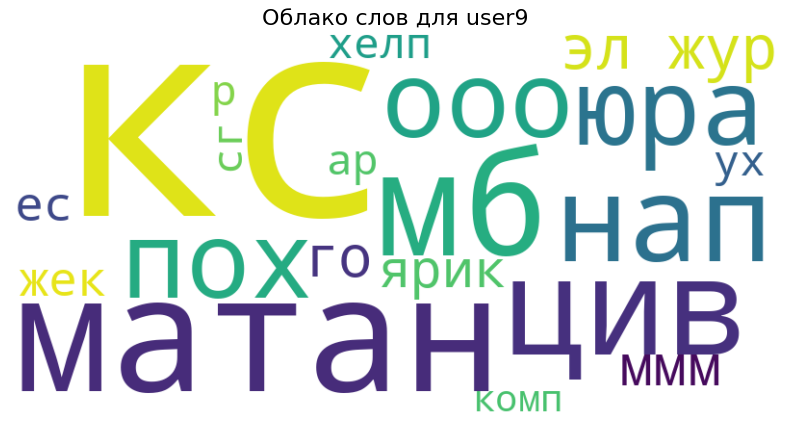

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def generate_wordcloud_for_author(top_entities_by_author):
    for author, entity_counts in top_entities_by_author.items():
        # Генерация облака слов на основе частоты сущностей
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(entity_counts))

        # Отображение облака слов
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')  # Отключаем оси
        plt.title(f"Облако слов для {author}", fontsize=16)
        plt.show()

# Генерация облаков слов для каждого автора
generate_wordcloud_for_author(top_entities)